## Digit Image Extraction

This notebook is used to extract digit image patches from previously cropped and labeled apartment images.  

Note that the patch selection is semi-automated and involves using edge detectors + morphological operators to infer where the digit is in an apartment image.  

This is then followed by a round of QA where every single image extracted is validated.

In [1]:
from cvutils.rectlabel import io as rectlabel_io
import os
import re
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as sk_io
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage import morphology
from skimage import feature

SOURCE_DATA_PATH = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset02')
#RESULT_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'DigitTraining')

# Image patches are first extracted to RESULT_DIR and then moved to VALIDATED_DIR after QA
RESULT_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'training', 'digit', 'r0.6', 'extract')
VALIDATED_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'training', 'digit', 'r0.6', 'validated')

MULTI_DIGIT_DIR = osp.join(RESULT_DIR, 'multi')
SINGLE_DIGIT_DIR = osp.join(RESULT_DIR, 'single')

# Initialize directory in which validated images will be stored
SINGLE_DIGIT_VALIDATED = osp.join(VALIDATED_DIR, 'single')

SOURCE_DATA_PATH, RESULT_DIR, MULTI_DIGIT_DIR, SINGLE_DIGIT_DIR, SINGLE_DIGIT_VALIDATED

('/lab/data/celldom/dataset/dataset02',
 '/lab/data/celldom/dataset/training/digit/r0.6',
 '/lab/data/celldom/dataset/training/digit/r0.6/multi',
 '/lab/data/celldom/dataset/training/digit/r0.6/single')

In [2]:
os.makedirs(MULTI_DIGIT_DIR, exist_ok=True)
os.makedirs(SINGLE_DIGIT_DIR, exist_ok=True)

In [3]:
df = pd.DataFrame(rectlabel_io.list_dir(SOURCE_DATA_PATH))
df.head()

,image_name,image_path,annot_path,annot_exists
0,BF_ST_014_APT_005Day0.jpg,/lab/data/celldom/dataset/dataset02/BF_ST_014_...,/lab/data/celldom/dataset/dataset02/annotation...,False
1,BF_ST_001_APT_001Day3.jpg,/lab/data/celldom/dataset/dataset02/BF_ST_001_...,/lab/data/celldom/dataset/dataset02/annotation...,True
2,BF_ST_005_APT_006Day0.jpg,/lab/data/celldom/dataset/dataset02/BF_ST_005_...,/lab/data/celldom/dataset/dataset02/annotation...,False
3,BF_ST_000_APT_002Day1.jpg,/lab/data/celldom/dataset/dataset02/BF_ST_000_...,/lab/data/celldom/dataset/dataset02/annotation...,True
4,BF_ST_007_APT_009Day0.jpg,/lab/data/celldom/dataset/dataset02/BF_ST_007_...,/lab/data/celldom/dataset/dataset02/annotation...,False


In [4]:
df.annot_exists.value_counts()

False    664
True     160
Name: annot_exists, dtype: int64

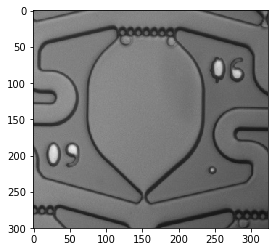

In [5]:
plt.imshow(sk_io.imread(df.iloc[8]['image_path']))

In [49]:
from scipy import ndimage as ndi
from skimage import morphology
from skimage import feature
from skimage import measure

class InvalidNumberOfDigitsException(Exception):
    pass

def extract(img, true_digits, pad_y=10, pad_x=10):
    assert img.ndim == 2
    assert img.dtype == np.uint8
    assert isinstance(true_digits, str)
    
    n_digit = len(true_digits)
    
    # Define sillouhette of digits
    img_obj_raw = feature.canny(img, sigma=1.0)
    img_obj_raw = morphology.closing(img_obj_raw)
    img_obj_raw = ndi.binary_fill_holes(img_obj_raw)
    img_obj = morphology.remove_small_objects(img_obj_raw, min_size=64)
    
    # Label the objects in the images (which is usually just a hull around digits)
    img_obj = morphology.label(img_obj)
    
    # Restrict to the n_digit largest images
    props = measure.regionprops(img_obj)
    order = list(np.argsort([p.area for p in props]))[(-n_digit):]
    props = [props[i] for i in order]
    
    # Now sort remainder from left to right
    # *According to docs: Centroid coordinate tuple (row, col)
    order = list(np.argsort([p.centroid[1] for p in props]))
    props = [props[i] for i in order]
    
    if len(props) != n_digit:
        fig, ax = plt.subplots(1, 1)
        ax.imshow(img_obj_raw)
        ax.set_title('Failed image num objects = {}'.format(len(props)))
        raise InvalidNumberOfDigitsException()
    
    digit_imgs = []
    for digit in props:
        # (min_row, min_col, max_row, max_col)
        bbox = digit.bbox
        minr = max(bbox[0] - pad_y, 0)
        maxr = min(bbox[2] + pad_y, img.shape[0])
        minc = max(bbox[1] - pad_x, 0)
        maxc = min(bbox[3] + pad_x, img.shape[1])
        digit_imgs.append(img[minr:maxr, minc:maxc])
        
    return digit_imgs
    

In [50]:
def prep(img):
    assert img.dtype == np.uint8
    assert img.ndim == 3
    assert img.shape[2] == 3
    assert np.all(img[..., 0] == img[..., 1])
    assert np.all(img[..., 0] == img[..., 2])
    img = img[..., 0]
    return img

def process(img_path, img_name):
    # Extract true st + apt num from file name (like "BF_ST_014_APT_004Day0.jpg") and ensure
    # that there are exactly 2 digits in each; Note: Ignore the leading 0 because there
    # are only 2 actual digits on the chips
    st_num, apt_num = re.findall('BF_ST_0(\d+)_APT_0(\d+)Day.*', img_name)[0]
    n_digit = 2
    assert len(st_num) == len(apt_num) == n_digit

    # Read in the image
    img = prep(sk_io.imread(img_path))

    # Crop out generous margins around approximate digit locations
    apt_crop = [(50, 120), (240, 310)]
    st_crop =  [(160, 230), (20, 90)]
    img_apt_num = img[slice(*apt_crop[0]), slice(*apt_crop[1])]
    img_st_num = img[slice(*st_crop[0]), slice(*st_crop[1])]

    # Extract individual digit images
    apt_digit_imgs = extract(img_apt_num, apt_num)
    st_digit_imgs = extract(img_st_num, st_num)
        
    res = []
    res += list(zip(apt_num, apt_digit_imgs, ['APT']*n_digit, list(range(n_digit))))
    res += list(zip(st_num, st_digit_imgs, ['ST']*n_digit, list(range(n_digit))))
    res = pd.DataFrame(res, columns=['digit', 'image', 'type', 'loc'])
    return img_apt_num, img_st_num, apt_num, st_num, res

Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_002_APT_004Day4.jpg
Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_007_APT_010Day0.jpg
Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_009_APT_009Day4.jpg
Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_008_APT_004Day1.jpg
Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_014_APT_007Day1.jpg
Failed to extract from /lab/data/celldom/dataset/dataset02/BF_ST_004_APT_003Day0.jpg
Processing complete for 824 images


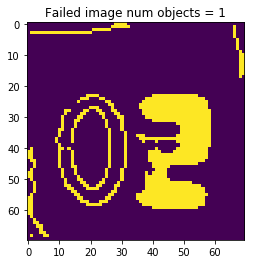

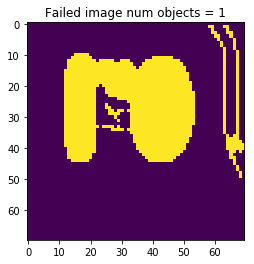

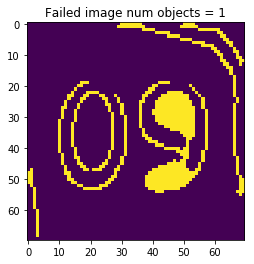

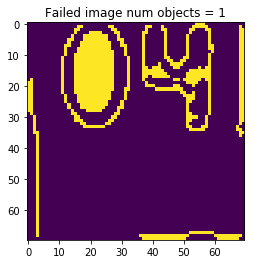

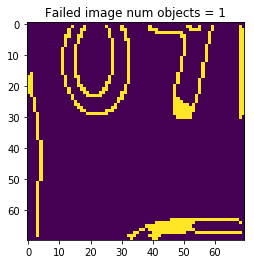

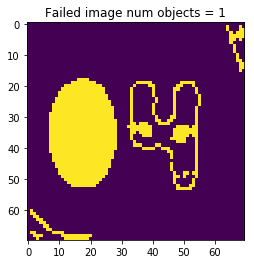

In [52]:
def process_digit_images(df, save=True, log=True):
    
    multi_digit_format = '{img_name}-{type}-{digits}.jpeg'
    single_digit_format = '{img_name}-{type}-{loc}-{digit}.jpeg'
    
    for i, r in df.iterrows():
        img_path, img_name = r['image_path'], r['image_name']
        
        # Remove file suffix
        if img_name.endswith('.jpg') or img_name.endswith('.jpeg'):
            img_name = '.'.join(img_name.split('.')[:-1])
        else:
            raise ValueError('Not sure how to deal with image named "{}"'.format(img_name))
        
        try:
            img_apt_num, img_st_num, apt_num, st_num, res = process(img_path, img_name)
        except InvalidNumberOfDigitsException:
            print('Failed to extract from', img_path)
            continue
        
        # Save multi-digit images
        apt_path = osp.join(MULTI_DIGIT_DIR, multi_digit_format.format(img_name=img_name, type='APT', digits=apt_num))
        st_path = osp.join(MULTI_DIGIT_DIR, multi_digit_format.format(img_name=img_name, type='ST', digits=st_num))
        if log:
            print('Saving apt digit image to "{}" (shape = {}, dtype = {})'.format(apt_path, img_apt_num.shape, img_apt_num.dtype))
            print('Saving st digit image to "{}" (shape = {}, dtype = {})'.format(st_path, img_st_num.shape, img_st_num.dtype))
        if save:
            sk_io.imsave(apt_path, img_apt_num)
            sk_io.imsave(st_path, img_st_num)
            
        # Save single-digit images
        for j, rr in res.iterrows():
            img = rr['image']
            path = osp.join(SINGLE_DIGIT_DIR, single_digit_format.format(
                img_name=img_name, type=rr['type'], loc=rr['loc'], digit=rr['digit']))
            if log:
                print('Saving digit image to "{}" (shape = {}, dtype = {})'.format(path, img.shape, img.dtype))
            if save:
                sk_io.imsave(path, img)
                
    print('Processing complete for {} images'.format(len(df)))
                
process_digit_images(df, save=True, log=False)
#process_digit_images(df[df['image_name'] == 'BF_ST_005_APT_008Day1.jpg'], save=False, log=False)

In [66]:
#plt.imshow(sk_io.imread('/lab/data/celldom/dataset/dataset02/BF_ST_012_APT_004Day2.jpg'))

### Spot Checking

In [53]:
!ls $SINGLE_DIGIT_DIR | wc -l

3272


In [108]:
import glob
files = pd.Series(glob.glob(osp.join(SINGLE_DIGIT_DIR, '*.jpeg')))
iterator = iter(files.sample(50))
def get_actual_digit(file):
    return osp.basename(file).replace('.jpeg', '').split('-')[-1]

In [109]:
pd.Series([get_actual_digit(f) for f in files]).value_counts().sort_index()

0    1513
1     538
2     185
3     180
4     182
5     157
6     133
7     126
8     132
9     126
dtype: int64

Actual: 0 File: /lab/data/celldom/dataset/training/digit/r0.6/single/BF_ST_004_APT_008Day4-ST-0-0.jpeg


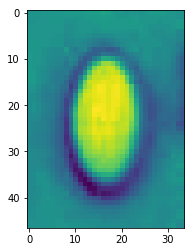

In [119]:
file = next(iterator)
print('Actual:', get_actual_digit(file), 'File:', file)
plt.imshow(sk_io.imread(file))

Bad examples:

- /lab/data/celldom/dataset/training/digit/r0.6/single/BF_ST_014_APT_010Day1-ST-1-4.jpeg

### Single Digit Full Scale QA

In [125]:
files = pd.Series(glob.glob(osp.join(SINGLE_DIGIT_DIR, '*.jpeg')))
batch_size = 8
batches = np.array_split(files, len(files) // batch_size)

In [136]:
batch_iter = iter(batches)

In [319]:
# idx = files.tolist().index('/lab/data/celldom/dataset/training/digit/r0.6/single/BF_ST_014_APT_009Day1-APT-1-9.jpeg')-0
# print(files[idx], get_actual_digit(files[idx]))
# plt.imshow(sk_io.imread(files[idx]))

In [500]:
files.tolist().index('/lab/data/celldom/dataset/training/digit/r0.6/single/BF_ST_002_APT_005Day2-ST-0-0.jpeg')

2799

In [560]:
# Repeatedly check 8 images at a time with this cell and record bad examples in the cell below:
from cvutils import visualize
batch = next(batch_iter, None)
if batch is None:
    print('No more batches to check')
else:
    print(batch.values)
    visualize.display_images(
        [sk_io.imread(f) for f in batch], 
        titles=['{} ({})'.format(get_actual_digit(f), osp.basename(f)) for f in batch]
    )

No more batches to check


In [578]:
bad_examples = [
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_006_APT_009Day2-APT-1-9.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_007Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_007Day1-APT-1-7.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_003Day1-APT-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_003Day1-ST-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_003Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_007Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_007Day1-APT-1-7.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_001Day1-APT-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_001Day1-ST-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_010Day1-ST-1-4.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_003Day1-ST-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_005Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_005Day1-APT-1-5.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_000_APT_010Day2-APT-0-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_000_APT_010Day2-APT-1-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_009Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_009Day1-APT-1-9.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_003Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_003Day1-APT-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_003Day1-ST-0-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_009Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_009Day1-APT-1-9.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_001Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_009Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_009Day1-APT-1-9.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_009Day1-ST-0-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_005Day1-ST-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_010Day1-APT-1-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_010Day2-APT-1-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_010Day3-APT-1-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_010Day4-APT-1-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_001Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_001Day1-APT-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_001Day1-ST-0-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_001Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_001Day1-APT-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_005_APT_001Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_005_APT_001Day1-APT-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_003_APT_008Day3-ST-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_014_APT_004Day1-APT-1-4.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_008_APT_003Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_005_APT_003Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_005_APT_003Day1-APT-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_003Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_003Day1-APT-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_003Day1-ST-0-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_005Day1-ST-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_001Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_002_APT_001Day1-APT-1-1.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_005Day1-APT-0-0.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_011_APT_005Day1-APT-1-5.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_003_APT_006Day3-ST-1-3.jpeg',
    '/lab/data/celldom/dataset/training/digit/r0.6/extract/single/BF_ST_007_APT_003Day1-ST-1-7.jpeg'
]

In [583]:
if not osp.exists(SINGLE_DIGIT_VALIDATED):
    os.makedirs(SINGLE_DIGIT_VALIDATED, exist_ok=True)
!rm $SINGLE_DIGIT_VALIDATED/*

rm: cannot remove '/lab/data/celldom/dataset/training/digit/r0.6/validated/single/*': No such file or directory


In [586]:
import glob
import shutil

# Get list of all raw images
raw_files = glob.glob(SINGLE_DIGIT_DIR + '/*.jpeg')

# Check that the expected number of raw files would be ignored
files_ignored = []
files_to_copy = []
for f in raw_files:
    if f in bad_examples:
        files_ignored.append(f)
    else:
        files_to_copy.append(f)
assert len(files_ignored) == len(bad_examples), '{} != {}'.format(len(files_ignored), len(bad_examples))

# Copy validated images
for f in files_to_copy:
    dest = osp.join(SINGLE_DIGIT_VALIDATED, osp.basename(f))
    shutil.copy(f, dest)
    
print('Finished copying {} validated images (of {} raw) to {}'.format(len(files_to_copy), len(raw_files), SINGLE_DIGIT_VALIDATED))

Finished copying 3219 validated images (of 3272 raw) to /lab/data/celldom/dataset/training/digit/r0.6/validated/single
